# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [ ]:
The data containts information from 17 campaigns occured between May 2008 and November 2010 and reached out to 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from tqdm import tqdm
from time import time
from sklearn.datasets import load_digits
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tools.eval_measures import rmse
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [9]:
# Check for null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [10]:
df.shape

(41188, 21)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab21f19550>,
      dtype=object)

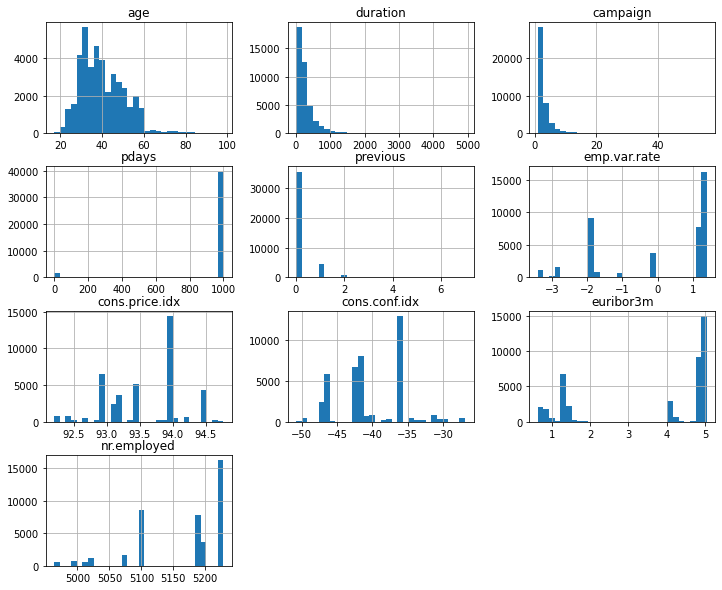

In [11]:
# Distribution graphs of the data
df.hist(bins=30, figsize=(12, 10))

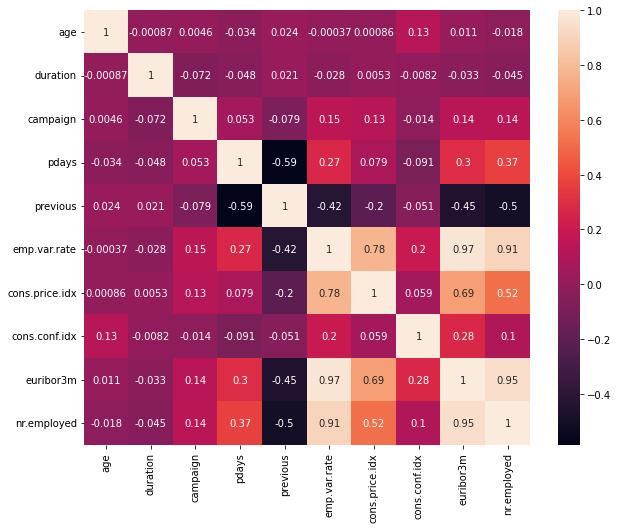

In [12]:
# Create Correlation Matrix to understand the correlation between numeric columns
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(df.corr(), annot=True)
# There is a high correlation between Euribor rate and Employment Variation Rate (0.97). 
# Followed by Euribor and Employee Count (0.95) and then by Employment Variation Rate and Employee Count (0.91).

In [13]:
# Defining numerical and categorical variables
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

In [14]:
df_no_outlier = df.copy()

In [15]:
# Remove outliers from the Numerical Column - Age using IQR
first_quartile = df['age'].quantile(.25)
third_quartile = df['age'].quantile(.75)
iqr = third_quartile - first_quartile 
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr
df_no_outlier = df.loc[(df['age']>lower) & (df['age']<upper)]

In [16]:
# Remove outliers from the Numerical Column - Duration using IQR
first_quartile = df_no_outlier['duration'].quantile(.25)
third_quartile = df_no_outlier['duration'].quantile(.75)
iqr = third_quartile - first_quartile 
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr
df_no_outlier = df_no_outlier.loc[(df_no_outlier['duration']>lower) & (df_no_outlier['duration']<upper)]

In [17]:
# Remove outliers from the Numerical Column - Campaign  using IQR
first_quartile = df_no_outlier['campaign'].quantile(.25)
third_quartile = df_no_outlier['campaign'].quantile(.75)
iqr = third_quartile - first_quartile 
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr
df_no_outlier = df_no_outlier.loc[(df_no_outlier['campaign']>lower) & (df_no_outlier['campaign']<upper)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab1b812310>,
      dtype=object)

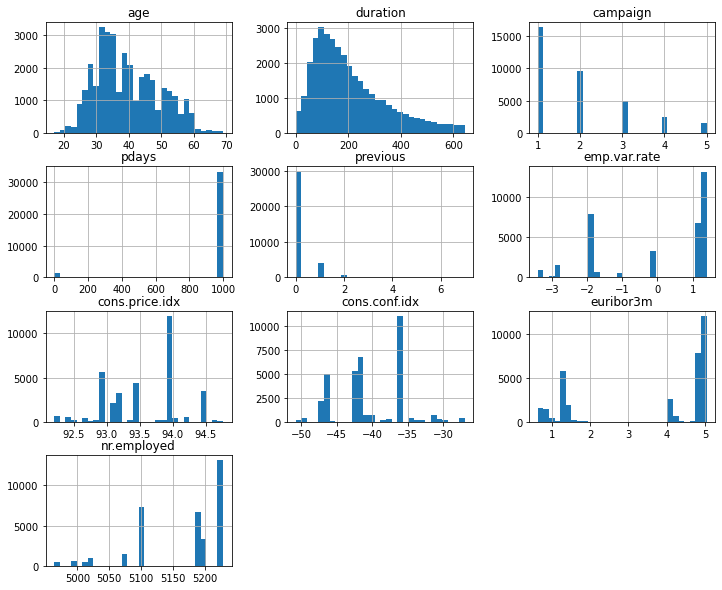

In [18]:
# Distribution graphs of the data with reduced outliers
df_no_outlier.hist(bins=30, figsize=(12, 10))

In [19]:
df_no_outlier.shape

(34634, 21)

#### Visualize the data and understand the correlation between numerical and categorical features in the dataframe

Text(0.5, 1.0, 'Campaign Acceptance Rate')

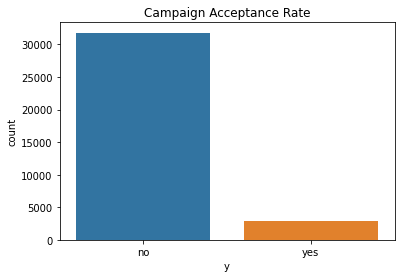

In [20]:
# Campaign Acceptance rate in the given dataset
sns.countplot(data=df_no_outlier, x='y') 
plt.title('Campaign Acceptance Rate')
#Out of the 34634 campaign responses (reduced outliers) recorded in this dataset, only 8.19% subscribed to a term deposit. 

In [21]:
# Campaign Acceptance rate based on age
px.histogram(df_no_outlier, x='age', color='y', title='Campaign Acceptance Rate based on Age')
# A high Campaign was targeted to the age group between 28 and 40, and the acceptance rate is also higher in this group

In [22]:
# Campaign Acceptance Rate based on Job
px.histogram(df_no_outlier, x='job', color='y', title='Campaign Acceptance Rate based on Job', text_auto=True)
# A high campaign was targeted to people with Admin and Blue-Collar jobs. People with Admin jobs shows a higher acceptance to term-deposit.

In [23]:
# Campaign Acceptance Rate based on Marital Status
px.histogram(df_no_outlier, x='marital', color='y', title='Campaign Acceptance Rate based on Marital Status', text_auto=True)
# A high campaign was targeted to people with 'Married' Marital Status and also shows a higher acceptance to term-deposit.

In [24]:
# Campaign Acceptance Rate based on Education
px.histogram(df_no_outlier, x='education', color='y', title='Campaign Acceptance Rate based on Education', text_auto=True)
# A high campaign was targeted to people with University and High-School degrees. People with University degree shows a higher acceptance to term-deposit.

In [25]:
# Campaign Acceptance Rate based on Credit Default
px.histogram(df_no_outlier, x='default', color='y', title='Campaign Acceptance Rate based on Credit Default', text_auto=True)
# A high campaign was targeted to people with 'No' credit default status and also shows a higher acceptance to term-deposit.

In [26]:
# Campaign Acceptance Rate based on Housing Loan
px.histogram(df_no_outlier, x='housing', color='y', title='Campaign Acceptance Rate based on Housing Loan', text_auto=True)
# A high campaign was targeted to people with an existing Housing Loan and the same shows a higher acceptance to term-deposit.

In [27]:
# Campaign Acceptance Rate based on Personal Loan
px.histogram(df_no_outlier, x='loan', color='y', title='Campaign Acceptance Rate based on Personal Loan', text_auto=True)
# A high campaign was targeted to people with no existing Personal Loan and the same shows a higher acceptance to term-deposit.

In [28]:
# Campaign Acceptance Rate based on Contact Type
px.histogram(df_no_outlier, x='contact', color='y', title='Campaign Acceptance Rate based on Contact Type', text_auto=True)
# A high campaign was targeted to people via cellphones and the same shows a higher acceptance to term-deposit.

In [29]:
# Campaign Acceptance Rate based on Month
px.histogram(df_no_outlier, x='month', color='y', title='Campaign Acceptance Rate based on Last Contact Month', text_auto=True)
# A high campaign was targeted to people during the month of 'May' and the same shows a higher acceptance to term-deposit.

In [30]:
# Campaign Acceptance Rate based on Day of Week
px.histogram(df_no_outlier, x='day_of_week', color='y', title='Campaign Acceptance Rate based on Last Contact Day of Week', text_auto=True)
# A high campaign was targeted to people on 'Mondays'. But, the acceptance rate to term-deposit is higher on 'Thursdays'.

In [31]:
# Campaign Acceptance Rate based on Contact Duration
px.histogram(df_no_outlier, x='duration', color='y', title='Campaign Acceptance Rate based on the Contact Duration')

Text(0.5, 1.0, 'Campaign Acceptance Rate based on Number of Contacts Performed')

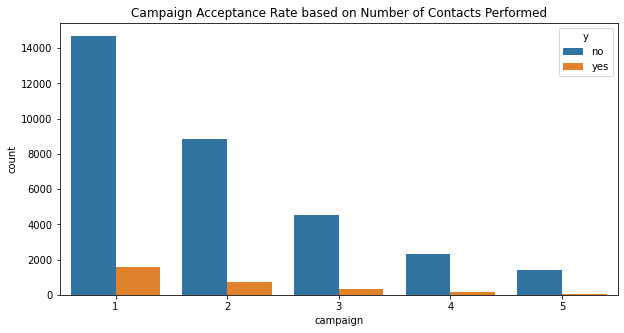

In [32]:
# Campaign Acceptance Rate based on Number of Contacts Performed
fig, ax = plt.subplots(figsize=(10,5)) 
sns.countplot(data=df_no_outlier, x='campaign', hue='y')
plt.title('Campaign Acceptance Rate based on Number of Contacts Performed')
# Higher campaign contacts actually produced very minimum acceptance to term-deposit.

Text(0.5, 1.0, 'Campaign Acceptance Rate based on PDays')

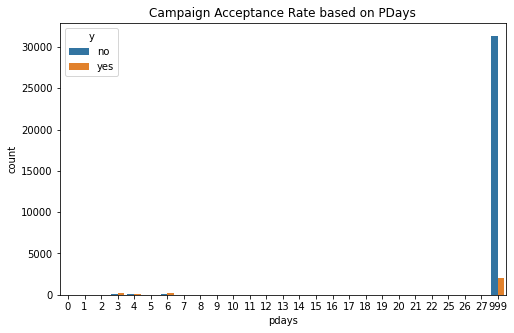

In [33]:
# Campaign Acceptance Rate based on pdays
fig, ax = plt.subplots(figsize=(8,5)) 
sns.countplot(data=df_no_outlier, x='pdays', hue='y')
plt.title('Campaign Acceptance Rate based on PDays')
# Most of the campaign outreach happend to customers that were never contacted before

Text(0.5, 1.0, 'Campaign Acceptance Rate based on previously contacted before')

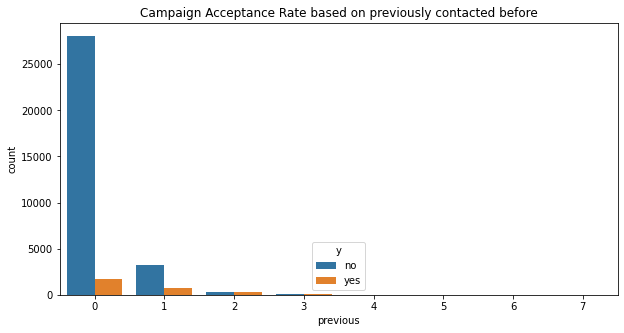

In [34]:
# Campaign Acceptance Rate based on previously contacted before
fig, ax = plt.subplots(figsize=(10,5)) 
sns.countplot(data=df_no_outlier, x='previous', hue='y')
plt.title('Campaign Acceptance Rate based on previously contacted before')
# Most of the campaign outreach happend to customers that were never contacted before

Text(0.5, 1.0, 'Campaign Acceptance Rate based on previous contact outcome')

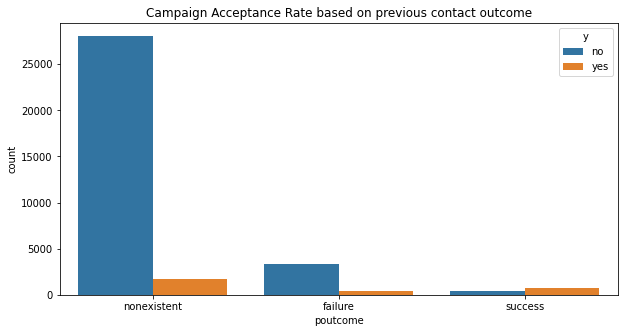

In [35]:
# Campaign Acceptance Rate based on previous contact outcome
fig, ax = plt.subplots(figsize=(10,5)) 
sns.countplot(data=df_no_outlier, x='poutcome', hue='y')
plt.title('Campaign Acceptance Rate based on previous contact outcome')
# Most of the campaign outreach happend to customers that were never contacted before and also shows a better acceptance rate to term-deposit.

Understanding Data based on Social and Economic Context Attributes

Text(0.5, 1.0, 'Campaign Acceptance Rate based on Employment Variation Rate')

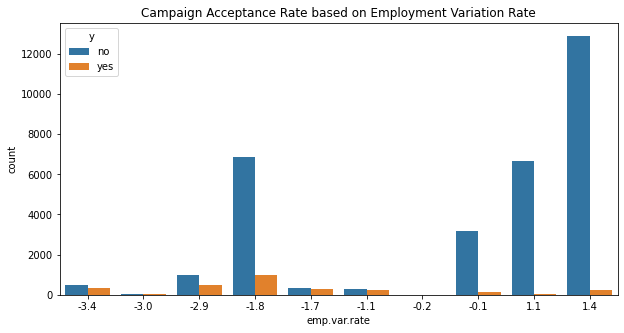

In [36]:
# Campaign Acceptance Rate based on Employment Variation Rate
fig, ax = plt.subplots(figsize=(10,5)) 
sns.countplot(data=df_no_outlier, x='emp.var.rate', hue='y')
plt.title('Campaign Acceptance Rate based on Employment Variation Rate')
# Most of the campaign outreach happend when the EVR is high. But, the acceptance and non-acceptance of term-deposits is equal when the the EVR is between -1.7 and -1.1.

Text(0.5, 1.0, 'Campaign Acceptance Rate based on Consumer Price Index')

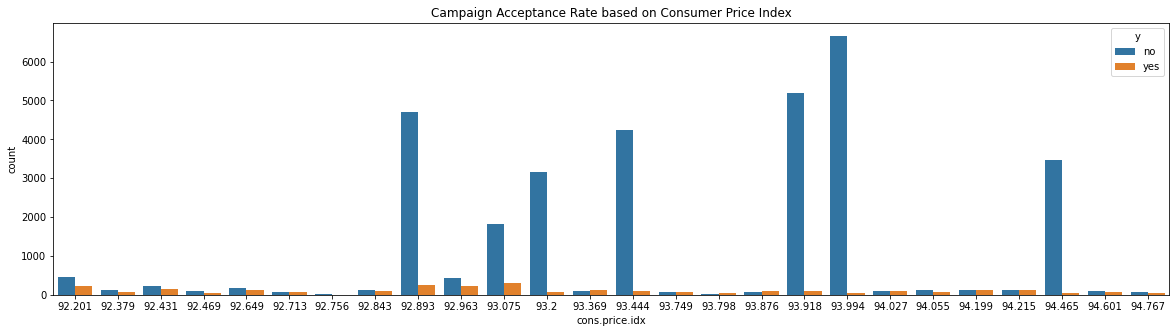

In [37]:
# Campaign Acceptance Rate based on Consumer Price Index
fig, ax = plt.subplots(figsize=(20,5)) 
sns.countplot(data=df_no_outlier, x='cons.price.idx', hue='y')
plt.title('Campaign Acceptance Rate based on Consumer Price Index')
# Most of the campaign outreach happend when the CPI is over 92.89. But, the acceptance and non-acceptance of term-deposits becomes equal when the the CPI is between 94.0 and 94.2.

Text(0.5, 1.0, 'Campaign Acceptance Rate based on Consumer Confidence Index')

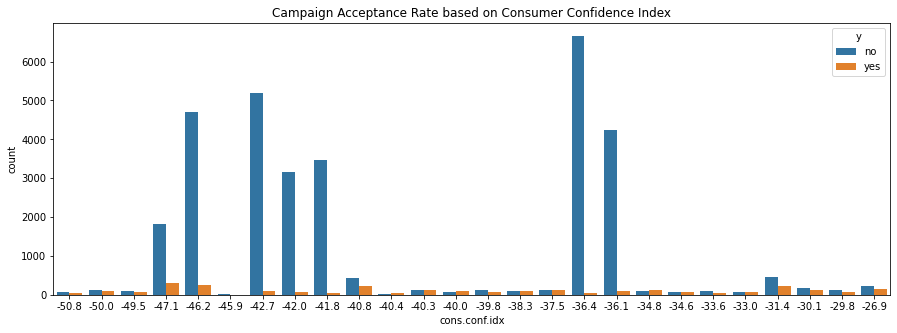

In [38]:
# Campaign Acceptance Rate based on Consumer Confidence Index
fig, ax = plt.subplots(figsize=(15,5)) 
sns.countplot(data=df_no_outlier, x='cons.conf.idx', hue='y')
plt.title('Campaign Acceptance Rate based on Consumer Confidence Index')
# Most of the campaign outreach happend when the CCI is low. But, the acceptance and non-acceptance of term-deposits is equal when the the CCI is between -38.3 and -37.5.

In [39]:
# Campaign Acceptance Rate based on euribor3m
px.histogram(df_no_outlier, x='euribor3m', color='y', title='Campaign Acceptance Rate based on euribor3m', text_auto=True)
# Most of the campaign outreach happend when the Euribor rates were high. But, the acceptance rate to term-deposits are high when the Euribor rates were low.

Text(0.5, 1.0, 'Campaign Acceptance Rate based on Number of Employees')

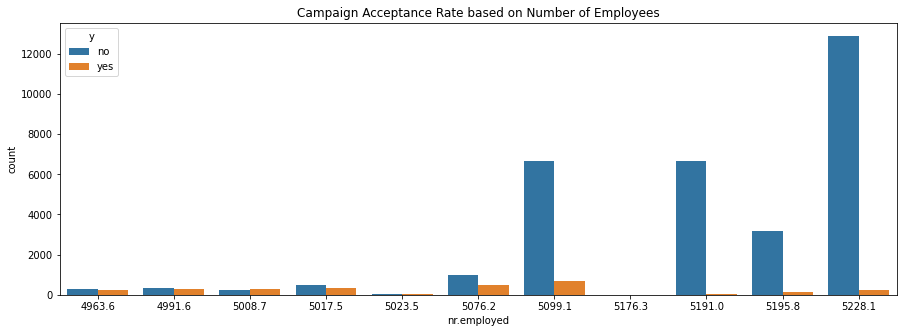

In [40]:
# Campaign Acceptance Rate based on Number of Employees
fig, ax = plt.subplots(figsize=(15,5)) 
sns.countplot(data=df_no_outlier, x='nr.employed', hue='y')
plt.title('Campaign Acceptance Rate based on Number of Employees')
# Most of the campaign outreach happend when the Employee Count is high. But, the acceptance and non-acceptance of term-deposits is equal when the employee count is minimal.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
#Business Objectives
#1. Identify the performance/accuracy score of Classifier Models
#2. Identify the factors that affect the customer acceptance of banking products via telephone marketing
#3. Summarize and provide future recommendations (if any)

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [42]:
#Converting Categorical Columns to Numerical Columns using Target Encoder
encoder_df = df_no_outlier.copy()
encoder = preprocessing.LabelEncoder()

def target_encoder(data):
    impute_ordinal = encoder.fit_transform(data)
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

for i in tqdm(range(len(cat_cols))):
    target_encoder(encoder_df[cat_cols[i]])

100%|██████████| 11/11 [00:00<00:00, 20.37it/s]


In [43]:
encoder_df = encoder_df.drop('duration', axis=1) #Dropping 'duration' column as it will not help predict the success of the markering campaign

In [46]:
encoder_df.reset_index()

index  age job marital education default housing loan contact month  \
0          0   56   3       1         0       0       0    0       1     6   
1          1   57   7       1         3       1       0    0       1     6   
2          2   37   7       1         3       0       2    0       1     6   
3          3   40   0       1         1       0       0    0       1     6   
4          4   56   7       1         3       0       0    2       1     6   
...      ...  ...  ..     ...       ...     ...     ...  ...     ...   ...   
34629  41181   37   0       1         6       0       2    0       0     7   
34630  41182   29  10       2         0       0       2    0       0     7   
34631  41184   46   1       1         5       0       0    0       0     7   
34632  41185   56   5       1         6       0       2    0       0     7   
34633  41186   44   9       1         5       0       0    0       0     7   

       ... campaign  pdays  previous  poutcome emp.var.rate  cons.price.idx  \
0      ...        1    999         0         1          1.1          93.994   
1      ...        1    999         0         1          1.1          93.994   
2      ...        1    999         0         1          1.1          93.994   
3      ...        1    999         0         1          1.1          93.994   
4      ...        1    999         0         1          1.1          93.994   
...    ...      ...    ...       ...       ...          ...             ...   
34629  ...        1    999         0         1         -1.1          94.767   
34630  ...        1      9         1         2         -1.1          94.767   
34631  ...        1    999         0         1         -1.1          94.767   
34632  ...        2    999         0         1         -1.1          94.767   
34633  ...        1    999         0         1         -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  y  
0              -36.4      4.857       5191.0  0  
1              -36.4      4.857       5191.0  0  
2              -36.4      4.857       5191.0  0  
3              -36.4      4.857       5191.0  0  
4              -36.4      4.857       5191.0  0  
...              ...        ...          ... ..  
34629          -50.8      1.028       4963.6  1  
34630          -50.8      1.028       4963.6  0  
34631          -50.8      1.028       4963.6  0  
34632          -50.8      1.028       4963.6  0  
34633          -50.8      1.028       4963.6  1  

[34634 rows x 21 columns]

In [47]:
#Standardizing the dataset
scaler = preprocessing.StandardScaler()
std_df = scaler.fit_transform(encoder_df.drop(['job','marital','education','default','housing','loan','contact','month','day_of_week','campaign',
                                               'previous','poutcome','emp.var.rate','y'], axis=1))

In [48]:
scaled_df = pd.DataFrame(std_df, columns = ['age','pdays','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'])

In [49]:
scaled_df['job'] = encoder_df['job'].values
scaled_df['marital'] = encoder_df['marital'].values
scaled_df['education'] = encoder_df['education'].values
scaled_df['default'] = encoder_df['default'].values
scaled_df['housing'] = encoder_df['housing'].values
scaled_df['loan'] = encoder_df['loan'].values
scaled_df['contact'] = encoder_df['contact'].values
scaled_df['month'] = encoder_df['month'].values
scaled_df['day_of_week'] = encoder_df['day_of_week'].values
scaled_df['campaign'] = encoder_df['campaign'].values
scaled_df['previous'] = encoder_df['previous'].values
scaled_df['poutcome'] = encoder_df['poutcome'].values
scaled_df['emp.var.rate'] = encoder_df['emp.var.rate'].values
scaled_df['y'] = encoder_df['y'].values

In [50]:
scaled_df.isnull().sum()

age               0
pdays             0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
previous          0
poutcome          0
emp.var.rate      0
y                 0
dtype: int64

In [51]:
scaled_df.describe()

age         pdays  cons.price.idx  cons.conf.idx  \
count  3.463400e+04  3.463400e+04    3.463400e+04   3.463400e+04   
mean  -1.308905e-16  2.232114e-16   -6.453437e-15   5.514636e-16   
std    1.000014e+00  1.000014e+00    1.000014e+00   1.000014e+00   
min   -2.332039e+00 -5.198117e+00   -2.362075e+00  -2.220096e+00   
25%   -7.833798e-01  1.935809e-01   -8.478155e-01  -4.727208e-01   
50%   -1.639162e-01  1.935809e-01   -2.085000e-01  -2.785681e-01   
75%    7.652792e-01  1.935809e-01    7.444093e-01   8.863486e-01   
max    3.036646e+00  1.935809e-01    2.083680e+00   2.935739e+00   

          euribor3m   nr.employed      campaign      previous  emp.var.rate  
count  3.463400e+04  3.463400e+04  34634.000000  34634.000000  34634.000000  
mean  -5.252034e-17  7.799270e-15      1.941156      0.176156      0.058298  
std    1.000014e+00  1.000014e+00      1.128839      0.494951      1.569052  
min   -1.713958e+00 -2.830377e+00      1.000000      0.000000     -3.400000  
25%   -1.304199e+00 -9.390798e-01      1.000000      0.000000     -1.800000  
50%    7.232415e-01  3.436527e-01      2.000000      0.000000      1.100000  
75%    7.832625e-01  8.614913e-01      3.000000      0.000000      1.400000  
max    8.317410e-01  8.614913e-01      5.000000      7.000000      1.400000

In [52]:
scaled_df.shape

(34634, 20)

In [53]:
scaled_df.head()

age     pdays  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  \
0  1.694475  0.193581        0.744409       0.886349   0.723241     0.343653   
1  1.797719  0.193581        0.744409       0.886349   0.723241     0.343653   
2 -0.267160  0.193581        0.744409       0.886349   0.723241     0.343653   
3  0.042572  0.193581        0.744409       0.886349   0.723241     0.343653   
4  1.694475  0.193581        0.744409       0.886349   0.723241     0.343653   

  job marital education default housing loan contact month day_of_week  \
0   3       1         0       0       0    0       1     6           1   
1   7       1         3       1       0    0       1     6           1   
2   7       1         3       0       2    0       1     6           1   
3   0       1         1       0       0    0       1     6           1   
4   7       1         3       0       0    2       1     6           1   

   campaign  previous poutcome  emp.var.rate  y  
0         1         0        1           1.1  0  
1         1         0        1           1.1  0  
2         1         0        1           1.1  0  
3         1         0        1           1.1  0  
4         1         0        1           1.1  0

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [54]:
X = scaled_df.drop('y', axis=1)
y = scaled_df['y'].astype('int')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [56]:
models = ['Baseline','Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM']
train_time = []
train_accuracy = []
test_accuracy = []
accuracy_score = []
AUC_score = []

In [57]:
dummy = DummyClassifier(strategy='uniform', random_state=42)
start_time = time()
dummy.fit(X_train, y_train)
train_time.append(time() - start_time)
train_accuracy.append(dummy.score(X_train, y_train))
test_accuracy.append(dummy.score(X_test, y_test))
accuracy_score.append('N/A')
AUC_score.append('N/A')

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [58]:
lgr = LogisticRegression(solver='liblinear', random_state=42)
start_time = time()
lgr.fit(X_train, y_train)
train_time.append(time() - start_time)
y_pred = lgr.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [59]:
train_accuracy.append(lgr.score(X_train, y_train))
test_accuracy.append(lgr.score(X_test, y_test))
accuracy_score.append(metrics.accuracy_score(y_test, y_pred))
fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
AUC_score.append(metrics.auc(fpr, tpr))

Text(0.5, 1.0, 'Logistic Regression')

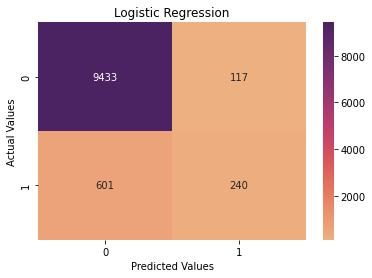

In [60]:
cm_plot = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='flare', fmt='d')
cm_plot.set_xlabel('Predicted Values')
cm_plot.set_ylabel('Actual Values')
plt.title("Logistic Regression")

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [61]:
from pandas.core.common import random_state
model_pipeline = []
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier(random_state=42))
model_pipeline.append(RandomForestClassifier(random_state=42))
model_pipeline.append(SVC(random_state=42))

In [62]:
cm_results = []

In [63]:
for model in model_pipeline:
  start_time = time()
  model.fit(X_train, y_train)
  train_time.append(time() - start_time)
  y_pred = model.predict(X_test)
  train_accuracy.append(model.score(X_train, y_train))
  test_accuracy.append(model.score(X_test, y_test))
  accuracy_score.append(metrics.accuracy_score(y_test, y_pred))
  fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
  AUC_score.append(metrics.auc(fpr, tpr))
  cm_results.append(confusion_matrix(y_test, y_pred))

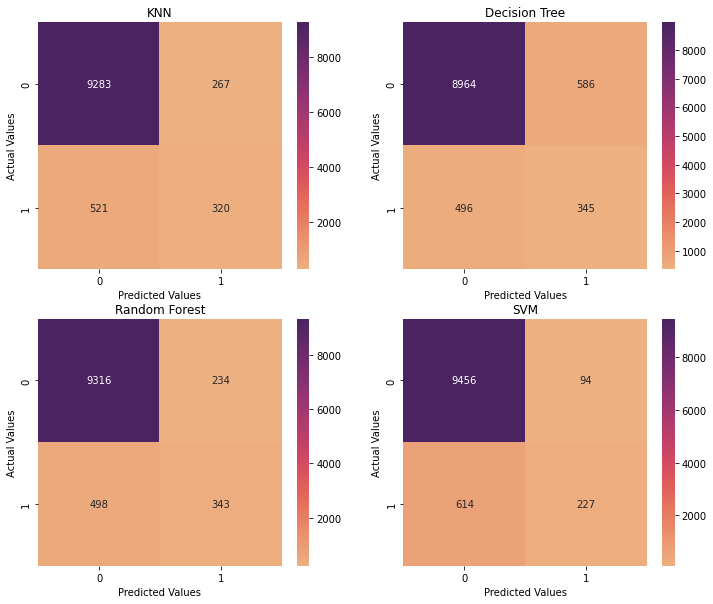

In [64]:
fig = plt.figure(figsize=(12, 10))
for i in range(len(cm_results)):
  cm = cm_results[i]
  model = models[i+2]
  sub = fig.add_subplot(2, 2, i+1).set_title(model)
  cm_plot = sns.heatmap(cm, annot=True, cmap='flare', fmt='d')
  cm_plot.set_xlabel('Predicted Values')
  cm_plot.set_ylabel('Actual Values')

In [65]:
results_df = ''

In [66]:
results_df = pd.DataFrame({'Model': models, 'Train_Time': train_time, 'Train_Score': train_accuracy, 'Test_Score': test_accuracy, 'Accuracy_Score': accuracy_score, 'AUC': AUC_score})
results_df

Model  Train_Time  Train_Score  Test_Score Accuracy_Score  \
0             Baseline    0.003282     0.498041    0.500241            N/A   
1  Logistic Regression    0.245142     0.929010    0.930902       0.930902   
2                  KNN    0.044781     0.939075    0.924165       0.924165   
3        Decision Tree    0.144646     0.997195    0.895871       0.895871   
4        Random Forest    2.233967     0.997195    0.929554       0.929554   
5                  SVM   13.435873     0.928845    0.931864       0.931864   

        AUC  
0       N/A  
1  0.636562  
2  0.676271  
3  0.674432  
4  0.691673  
5  0.630037

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
# More feature engineering and exploration. For example, should we keep the gender feature? Why or why not?
# Answer: The Gender Feature is not available in the dataset and unable to answer to this question

In [78]:
models = ['Logistic Regression Grid', 'KNN Grid', 'Decision Tree Grid', 'Random Forest Grid', 'SVM Grid']
best_params = []
fit_time = []
acc_score = []
recall_score = []
prec_score = []
f1_score = []
r2_score = []
roc_auc_score = []

#### Logistic Regression and GridSearchCV

In [79]:
# Applying Hyperparameter and GridSearchCV - LogisticRegression and Performance Metrics
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1-Lasso l2-Ridge
lgr = LogisticRegression()
lgr_cv=GridSearchCV(lgr, grid, cv=10)
lgr_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [80]:
lgr_cv.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [81]:
#Adjust Performance Metrics
lgr2=LogisticRegression(C=0.1, penalty="l2", random_state=42) 
start_time = time()
lgr2.fit(X_train,y_train)
train_time = time() - start_time

In [82]:
y_pred = lgr2.predict(X_test)

In [83]:
print(metrics.confusion_matrix(y_test, y_pred))

[[9442  108]
 [ 601  240]]


In [84]:
best_params.append(lgr_cv.best_params_)
fit_time.append(train_time)
acc_score.append(metrics.accuracy_score(y_test, y_pred))
recall_score.append(metrics.recall_score(y_test, y_pred))
prec_score.append(metrics.precision_score(y_test, y_pred))
f1_score.append(metrics.f1_score(y_test, y_pred))
r2_score.append(metrics.r2_score(y_test, y_pred))
roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred))

Feature: 0, Score: 0.04358
Feature: 1, Score: -0.18370
Feature: 2, Score: 0.36511
Feature: 3, Score: 0.07624
Feature: 4, Score: 0.80901
Feature: 5, Score: -0.88872
Feature: 6, Score: 0.00722
Feature: 7, Score: 0.14266
Feature: 8, Score: 0.06047
Feature: 9, Score: -0.54243
Feature: 10, Score: -0.00857
Feature: 11, Score: 0.00315
Feature: 12, Score: -0.61929
Feature: 13, Score: -0.11116
Feature: 14, Score: 0.07746
Feature: 15, Score: -0.05971
Feature: 16, Score: -0.06671
Feature: 17, Score: 0.44322
Feature: 18, Score: -0.85150


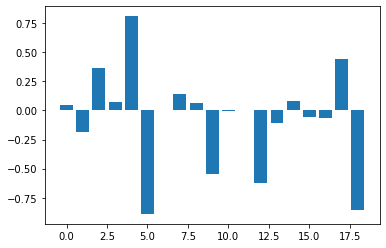

In [87]:
from matplotlib import pyplot 
importance = lgr2.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
#Top 3 Feature Importance - euribor3m, poutcome, cons.price.index

#### KNN and GridSearchCV

In [88]:
# Applying Hyperparameter and GridSearchCV - LogisticRegression and Performance Metrics
param_grid = dict(n_neighbors=list(range(1, 22)))
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', verbose=1)
knn_cv.fit(X_train, y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21]},
             scoring='accuracy', verbose=1)

In [89]:
knn_cv.best_params_

{'n_neighbors': 18}

In [90]:
#Adjust Performance Metrics
knn2=KNeighborsClassifier(n_neighbors=18)
start_time = time()
knn2.fit(X_train,y_train)
train_time = time() - start_time

In [91]:
y_pred = knn2.predict(X_test)

In [92]:
print(metrics.confusion_matrix(y_test, y_pred))

[[9416  134]
 [ 598  243]]


In [93]:
best_params.append(knn_cv.best_params_)
fit_time.append(train_time)
acc_score.append(metrics.accuracy_score(y_test, y_pred))
recall_score.append(metrics.recall_score(y_test, y_pred))
prec_score.append(metrics.precision_score(y_test, y_pred))
f1_score.append(metrics.f1_score(y_test, y_pred))
r2_score.append(metrics.r2_score(y_test, y_pred))
roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred))

#### Decision Tree and GridSearchCV

In [94]:
params = {'max_depth': [1, 3, 5, 7, 11, 13, 15, 17, 19, 21, 23],
         'min_samples_split': [1, 50, 2],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [1]}
dtree = DecisionTreeClassifier()
dtree_cv = GridSearchCV(dtree, params, cv=10)
dtree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 11, 13, 15, 17, 19, 21, 23],
                         'min_samples_leaf': [1],
                         'min_samples_split': [1, 50, 2]})

In [95]:
dtree_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 50}

In [96]:
#Adjust Performance Metrics
dtree2=DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=1, min_samples_split=50, random_state=42)
start_time = time()
dtree2.fit(X_train,y_train)
train_time = time() - start_time

In [97]:
y_pred = dtree2.predict(X_test)

In [98]:
print(metrics.confusion_matrix(y_test, y_pred))

[[9347  203]
 [ 535  306]]


In [99]:
best_params.append(dtree_cv.best_params_)
fit_time.append(train_time)
acc_score.append(metrics.accuracy_score(y_test, y_pred))
recall_score.append(metrics.recall_score(y_test, y_pred))
prec_score.append(metrics.precision_score(y_test, y_pred))
f1_score.append(metrics.f1_score(y_test, y_pred))
r2_score.append(metrics.r2_score(y_test, y_pred))
roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred))

Text(0.5, 0, 'X_train Values')

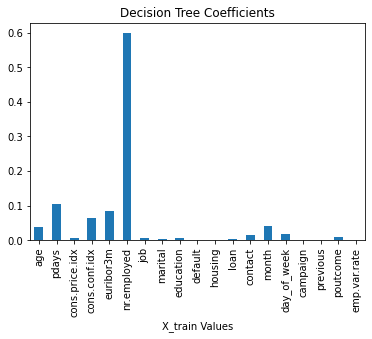

In [101]:
dtree_coeffs = pd.Series(dtree2.feature_importances_, index=X_train.columns)
dtree_coeffs.plot(kind='bar')
plt.title('Decision Tree Coefficients')
plt.xlabel('X_train Values')
#Top 3 Feature Importance - No. of Employees, pdays, euribor3m 

#### RandomForest and GridSearchCV

In [102]:
params = {'n_estimators': [1, 3, 5, 7, 11], 
          'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth' : [1, 3, 5, 7, 11, 13, 15],
          'criterion' :['gini', 'entropy']}
rfc = RandomForestClassifier()
rfc_cv = GridSearchCV(rfc, params, cv=10)
rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 11, 13, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 11]})

In [103]:
rfc_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 'log2',
 'n_estimators': 11}

In [104]:
#Adjust Performance Metrics
rfc2=RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2', n_estimators=11, random_state=42)
start_time = time()
rfc2.fit(X_train,y_train)
train_time = time() - start_time

In [105]:
y_pred = rfc2.predict(X_test)

In [106]:
print(metrics.confusion_matrix(y_test, y_pred))

[[9396  154]
 [ 571  270]]


In [107]:
best_params.append(dtree_cv.best_params_)
fit_time.append(train_time)
acc_score.append(metrics.accuracy_score(y_test, y_pred))
recall_score.append(metrics.recall_score(y_test, y_pred))
prec_score.append(metrics.precision_score(y_test, y_pred))
f1_score.append(metrics.f1_score(y_test, y_pred))
r2_score.append(metrics.r2_score(y_test, y_pred))
roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred))

Text(0.5, 0, 'X_train Values')

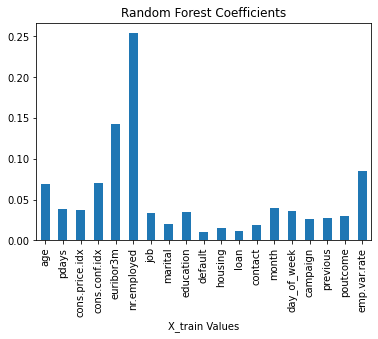

In [108]:
rfc_coeffs = pd.Series(rfc2.feature_importances_, index=X_train.columns)
rfc_coeffs.plot(kind='bar')
plt.title('Random Forest Coefficients')
plt.xlabel('X_train Values')
#Top 3 Feature Importance - No. of Employees, euribor3m , emp.var.rate

#### SVC and GridSearchCV

In [110]:
params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
         'gamma': [0.1, 1.0, 10.0, 100.0]}
svc = SVC()
svc_cv = GridSearchCV(svc, params, cv=10)
svc_cv.fit(X_train.sample(1000), y_train.sample(1000)) #To save time and computing resource, I applied gridsearch only to 1000 sample data.

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'gamma': [0.1, 1.0, 10.0, 100.0],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']})

In [111]:
svc_cv.best_params_

{'gamma': 0.1, 'kernel': 'rbf'}

In [112]:
#Adjust Performance Metrics
svc2=SVC(gamma=0.1, kernel='rbf')
start_time = time()
svc2.fit(X_train,y_train)
train_time = time() - start_time

In [113]:
y_pred = svc2.predict(X_test)

In [114]:
print(metrics.confusion_matrix(y_test, y_pred))

[[9405  145]
 [ 602  239]]


In [115]:
best_params.append(svc_cv.best_params_)
fit_time.append(train_time)
acc_score.append(metrics.accuracy_score(y_test, y_pred))
recall_score.append(metrics.recall_score(y_test, y_pred))
prec_score.append(metrics.precision_score(y_test, y_pred))
f1_score.append(metrics.f1_score(y_test, y_pred))
r2_score.append(metrics.r2_score(y_test, y_pred))
roc_auc_score.append(metrics.roc_auc_score(y_test, y_pred))

In [116]:
results_df1 = ''

In [117]:
results_df1 = pd.DataFrame({'Model': models, 'Best_Params': best_params, 'Train_Time': fit_time, 'Accuracy_Score': acc_score, 'Recall_Score': recall_score, 'Precision_Score': prec_score, 'F1_Score': f1_score, 'R2_Score': r2_score, 'ROC_AUC_Score': roc_auc_score})
results_df1

Model  \
0  Logistic Regression Grid   
1                  KNN Grid   
2        Decision Tree Grid   
3        Random Forest Grid   
4                  SVM Grid   

                                         Best_Params  Train_Time  \
0                        {'C': 0.1, 'penalty': 'l2'}    0.971839   
1                                {'n_neighbors': 18}    0.037301   
2  {'criterion': 'entropy', 'max_depth': 7, 'min_...    0.093384   
3  {'criterion': 'entropy', 'max_depth': 7, 'min_...    0.243633   
4                    {'gamma': 0.1, 'kernel': 'rbf'}   36.739471   

   Accuracy_Score  Recall_Score  Precision_Score  F1_Score  R2_Score  \
0        0.931768      0.285375         0.689655  0.403701  0.082715   
1        0.929554      0.288942         0.644562  0.399015  0.052958   
2        0.928977      0.363853         0.601179  0.453333  0.045196   
3        0.930228      0.321046         0.636792  0.426877  0.062015   
4        0.928111      0.284185         0.622396  0.390204  0.033552   

   ROC_AUC_Score  
0       0.637033  
1       0.637455  
2       0.671298  
3       0.652460  
4       0.634501

##### Questions